In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from config.config import *
from libs.common import *

c:\Users\Admin\Data\ads_fraud_detection
c:/Users/Admin/Data/ads_fraud_detection


In [2]:
save_dir=f"{exps_dir}/exp2"
if os.path.exists(save_dir) == False: 
  os.makedirs(save_dir, exist_ok=True)



test_size=0.33
seed=42

In [3]:
feature_selection=dict(np.load(f'{save_dir}/feature_model_selection.npz',allow_pickle=True))['feature_model_selection']
feature_selection = {key: value for key, value in feature_selection.item().items()}
feature_selection

{'LR': ['Age',
  'AgeOfPolicyHolder',
  'AgentType',
  'BasePolicy',
  'Fault',
  'MaritalStatus',
  'PoliceReportFiled',
  'PolicyType',
  'VehicleCategory',
  'WitnessPresent'],
 'LDA': ['AccidentArea',
  'Age',
  'AgeOfPolicyHolder',
  'BasePolicy',
  'Days_Policy_Claim',
  'Fault',
  'MaritalStatus',
  'NumberOfCars',
  'PoliceReportFiled',
  'VehicleCategory'],
 'DTC': ['Age',
  'AgeOfVehicle',
  'BasePolicy',
  'Fault',
  'Make',
  'PastNumberOfClaims',
  'PolicyNumber',
  'RepNumber',
  'week_claimed',
  'week_incident'],
 'RD': ['Age',
  'AgeOfVehicle',
  'BasePolicy',
  'Fault',
  'Make',
  'PolicyNumber',
  'PolicyType',
  'VehicleCategory',
  'week_claimed',
  'week_incident'],
 'KNC': ['DayOfWeek',
  'AccidentArea',
  'WeekOfMonthClaimed',
  'MaritalStatus',
  'Fault',
  'PolicyType',
  'VehicleCategory',
  'DriverRating',
  'AgeOfVehicle',
  'AgeOfPolicyHolder',
  'BasePolicy'],
 'GNB': ['DayOfWeek',
  'AccidentArea',
  'WeekOfMonthClaimed',
  'MaritalStatus',
  'Fault',
 

* kiểm tra và tạo các thư mục (nếu chưa có)
* tập test 33%

# 5. Xây dựng và đánh giá mô hình học sâu Neutual Network

In [4]:
bg_model=joblib.load(f'{save_dir}/bg_model.joblib')
rf_model=joblib.load(f'{save_dir}/rf_model.joblib')
svm_model=joblib.load(f'{save_dir}/svm_model.joblib')

In [5]:
x_train=pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train=pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test=pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test=pd.read_excel(f'{save_dir}/y_test.xlsx')
class_weights_dict=dict(np.load(f'{save_dir}/class_weights_dict.npz',allow_pickle=True))['class_weights_dict']
class_weights_dict = {key: value for key, value in class_weights_dict.item().items()}
class_weights_dict

{0: 0.5317035512094699, 1: 8.385551948051948}

In [6]:


# Dữ liệu label đã được mã hóa
def oneHot(arr):
    labels = np.array(arr)
    encoder = OneHotEncoder(sparse=False)
    
    labels_reshaped = labels.reshape(-1, 1)
    
    encoder.fit(labels_reshaped)
    
    onehot_labels = encoder.transform(labels_reshaped)
    # onehot_labels=pd.DataFrame(onehot_labels)
    return onehot_labels

y_train_onehot=oneHot(y_train)
y_test_onehot=oneHot(y_test)
print(y_test_onehot.shape,y_train_onehot.shape)


(5089, 2) (19430, 2)


In [7]:
y_test_onehot.reshape(-1, 1)
print(y_test_onehot.shape)

(5089, 2)


In [8]:
x_test.shape

(5089, 34)

In [9]:
x_train.shape

(19430, 34)

In [19]:
import tensorflow as tf

def f1_loss(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)  # Chọn lớp thật
    y_pred = tf.argmax(y_pred, axis=1)  # Chọn lớp dự đoán

    # Tính Precision và Recall
    true_positives = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    precision = true_positives / (tf.reduce_sum(tf.cast(y_pred, tf.float32)) + tf.keras.backend.epsilon())
    recall = true_positives / (tf.reduce_sum(tf.cast(y_true, tf.float32)) + tf.keras.backend.epsilon())

    # Tính F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1  # Trả về loss (1 - F1)


In [11]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [12]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [14]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [20]:
def multi_loss(y_true, y_pred):
    # # Tính toán các loss function riêng lẻ
    focal__loss = focal_loss(y_true,y_pred)
    f1__loss = f1_loss(y_true,y_pred)
    dice__loss = dice_coef_loss(y_true,y_pred)
    focal_weight = 0.3
    f1_weight = 0.5
    dice_weight = 0.2

    total_loss = (focal_weight * focal__loss) + (f1_weight * f1__loss) + (dice_weight * dice__loss)

    return total_loss

#### * Xây dựng model:

In [21]:

early_stopping = EarlyStopping(monitor='f1_score',
                                mode='max',
    min_delta=0.00005,
    patience=100,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='f1_score',
    mode='max',
    factor=0.5,
    patience=10,
    min_lr=0.000001,
    verbose=1,
)
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',  # Đường dẫn để lưu model
    monitor='f1_score',  # Theo dõi val_loss
    mode='max',
    save_best_only=True,  # Lưu lại chỉ model có val_loss tốt nhất
    verbose=1  # Hiển thị thông báo khi lưu model
)



#### * Xây dựng Stacked_model:

In [22]:


learning_rate=0.1
tabnet_params = {
    "decision_dim": 16,
    "attention_dim": 16,
    "n_steps": 3,
    "n_shared_glus": 2,
    "n_dependent_glus": 2,
    "relaxation_factor": 1.3,
    "epsilon": 1e-15,
    "momentum": 0.98,
    "mask_type": "softmax", # can be 'sparsemax' or 'softmax'
    "lambda_sparse": 1e-3, 
    "virtual_batch_splits": 8 #number of splits for ghost batch normalization, ideally should evenly divide the batch_size
}



### Classification
model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', **tabnet_params)
# model = TabNetClassifier(n_classes = 2, out_activation = 'softmax', 
#     kernel_regularizer=l2(0.01), **tabnet_params)
# model.compile(loss = 'categorical_crossentropy', optimizer = )
# model.fit(x_train, y_train, epochs = 100, batch_size = 1024)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',,f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_9cat_loss, metrics=['accuracy',,f1_score])
model.compile(optimizer=Adam(lr=learning_rate), loss=multi_loss, metrics=['accuracy',f1_score])

early_stopping = EarlyStopping(monitor='val_accuracy',
    min_delta=0.00005,
    patience=60,
    verbose=1,
    restore_best_weights=True,
)

model_checkpoint = ModelCheckpoint('best_model', monitor='val_loss', save_best_only=True, save_format='tf')


lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=20,
    min_lr=0.000001,
    verbose=1,
)


In [23]:
model.fit(x=x_train,y=y_train_onehot,
          validation_data=(x_test,y_test_onehot),
          batch_size=64,epochs= 1200,class_weight=class_weights_dict, callbacks=[early_stopping,lr_scheduler])


Epoch 1/1200
304/304 [==============================] - 107s 55ms/step - loss: 0.2178 - accuracy: 0.7191 - f1_score: 0.7191 - val_loss: 0.4873 - val_accuracy: 0.7611 - val_f1_score: 0.7607 - lr: 0.0010
Epoch 2/1200
304/304 [==============================] - 11s 38ms/step - loss: 0.1585 - accuracy: 0.8148 - f1_score: 0.8149 - val_loss: 0.4786 - val_accuracy: 0.7778 - val_f1_score: 0.7775 - lr: 0.0010
Epoch 3/1200
304/304 [==============================] - 11s 37ms/step - loss: 0.1440 - accuracy: 0.8329 - f1_score: 0.8330 - val_loss: 0.4769 - val_accuracy: 0.8035 - val_f1_score: 0.8032 - lr: 0.0010
Epoch 4/1200
304/304 [==============================] - 11s 37ms/step - loss: 0.1357 - accuracy: 0.8429 - f1_score: 0.8428 - val_loss: 0.4794 - val_accuracy: 0.8009 - val_f1_score: 0.8009 - lr: 0.0010
Epoch 5/1200
304/304 [==============================] - 11s 35ms/step - loss: 0.1292 - accuracy: 0.8512 - f1_score: 0.8512 - val_loss: 0.4703 - val_accuracy: 0.8090 - val_f1_score: 0.8091 - lr: 0

In [24]:
model.summary()

Model: "tab_net_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder_1 (TabNetE  multiple                  26880     
 ncoder)                                                         
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 26912 (105.12 KB)
Trainable params: 24592 (96.06 KB)
Non-trainable params: 2320 (9.06 KB)
_________________________________________________________________


#### * Kết quả đánh giá mô hình:

In [25]:
model.summary()

Model: "tab_net_classifier_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_encoder_1 (TabNetE  multiple                  26880     
 ncoder)                                                         
                                                                 
 classifier (Dense)          multiple                  32        
                                                                 
Total params: 26912 (105.12 KB)
Trainable params: 24592 (96.06 KB)
Non-trainable params: 2320 (9.06 KB)
_________________________________________________________________


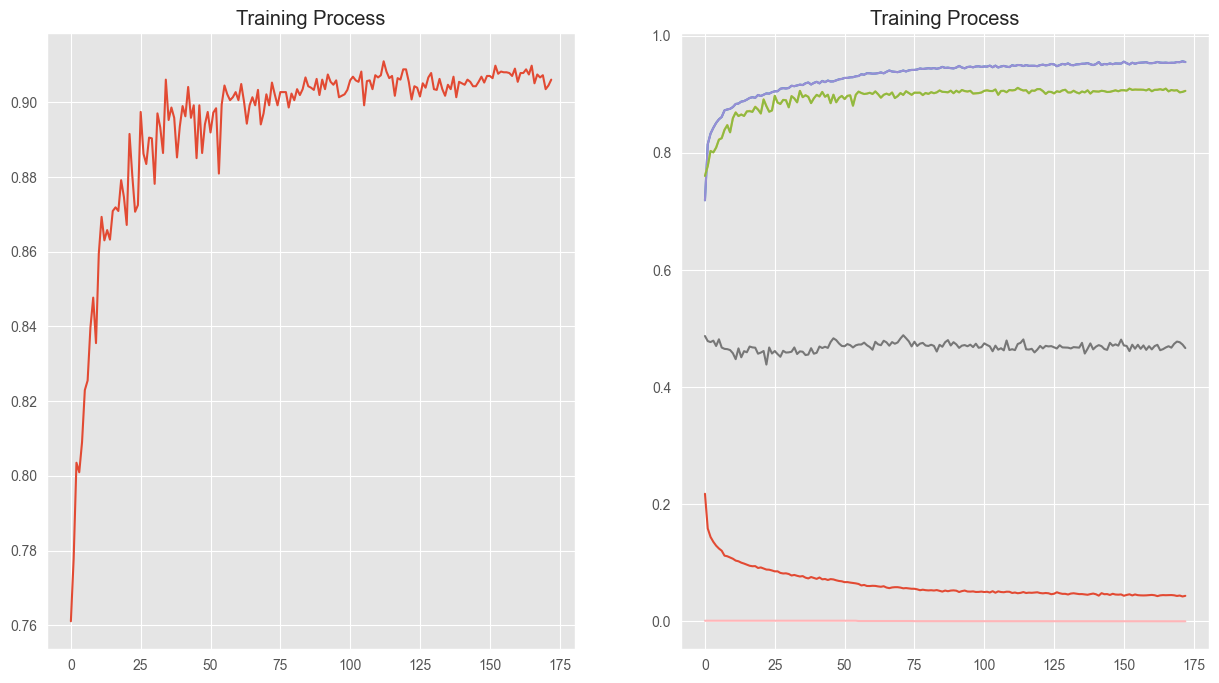

<Figure size 640x480 with 0 Axes>

In [26]:
history=model.history.history
fig,axes=plt.subplots(1,2, figsize=(15,8))
axes[0].plot(pd.DataFrame(history['val_accuracy']))
axes[0].set_title('Training Process')
axes[1].plot(pd.DataFrame(history))
axes[1].set_title('Training Process')
plt.show()
plt.savefig('train.png')

In [27]:
y_test_labels = np.argmax(y_test_onehot, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test_labels, predictions)
accuracy


160/160 [==============================] - 1s 3ms/step


0.9109844763214777

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.9109844763214777
Classification Report:
              precision    recall  f1-score   support

           1       0.20      0.15      0.17       307
           0       0.95      0.96      0.95      4782

    accuracy                           0.91      5089
   macro avg       0.57      0.56      0.56      5089
weighted avg       0.90      0.91      0.91      5089



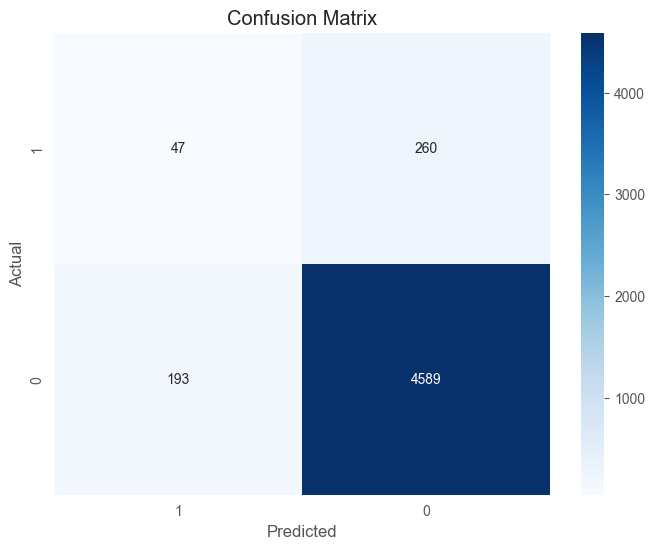

In [29]:
# Dự đoán


# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

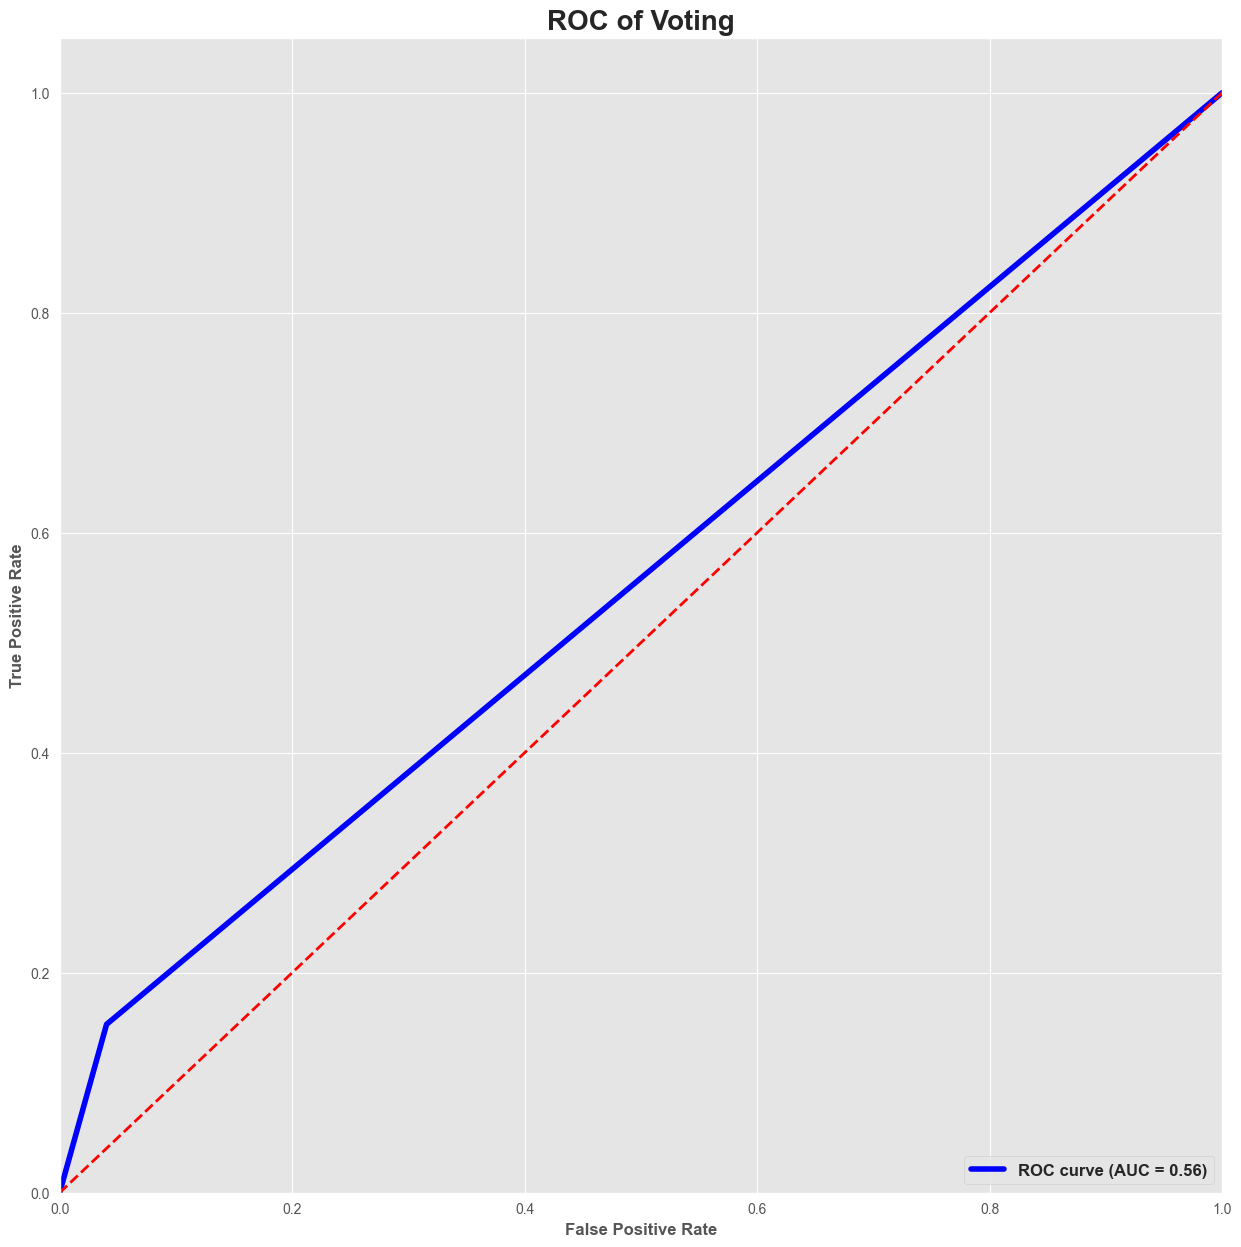

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

fpr, tpr, _ = roc_curve(y_test, predictions)
    
roc_auc = auc(fpr, tpr)

ax.plot(fpr, tpr, lw=4, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  
ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   
ax.set_title(f'ROC of Voting',fontsize=20, weight='bold')  
ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'}) 
plt.show()

In [24]:
def check_result(prediction):
    prediction = (prediction > 0.2).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [25]:
# solandung=0
# hopdonggianlan=0
# for indx in range(len(x_test)):
#     y_predict = stacked_model.predict(stacked_input)
#     stacked_pred_labels = y_predict.argmax(axis=1)

#     #print(y_predict[0][0])
#     Y_check = check_result(y_test.iloc[indx])
#     print('True:', Y_check)
#     print('Predicted:', check_result(stacked_pred_labels[indx]))
#     print("----------------------------")
#     if Y_check==check_result(stacked_pred_labels[indx]):
#         solandung+=1
#         if Y_check=='Y':
#             hopdonggianlan+=1
    

160/160 [==============================] - 0s 761us/step


AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['fraud_reported']==1]))*100}% so với thực tế")


Số lần dự đoán đúng: 275 chiếm khoảng 83.33333333333334% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 75 chiếm khoảng 85.22727272727273% so với thực tế
